In [1]:
%%html
<style>.text_cell .rendered_html * {direction: rtl; text-align: right;}</style>

# مقدمه:

هدف این پرژه پیاده سازی شبکه عصبی  با استفاده از کتابخانه numpy، برای classification داده های تصویری می باشد.  
با استفاده از شبکه عصبی و پیدا کردن هایپر پارامتر های بهینه مدل را آموزش می دهیم و خطا و دقت آن را به دست می آوریم. و از عملکرد خوب آن برای داده های جدید مطمئن می شویم.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

ابتدا داده ها را با استفاده از کتابخانه pandas می خوانیم.

تصاویر را X و label  ها را در Y ذخیره می کنیم.

In [3]:
X_test = pd.read_csv("test_images.csv", index_col=0).to_numpy()
Y_test = pd.read_csv("test_labels.csv", index_col=0).to_numpy()
X_train = pd.read_csv("train_images.csv", index_col=0).to_numpy()
Y_train = pd.read_csv("train_labels.csv", index_col=0).to_numpy()
Y_train = np.squeeze(Y_train)
Y_test = np.squeeze(Y_test)

##### plot image

برای رسم داده ها آن ها را به فرمت ۲۸*۲۸ در می آوریم و سپس با استفاده از  imshow آن را رسم می کنیم. 

In [4]:
def plot_image(image, label):
    plt.title(f'label: {label}')
    image = image.reshape(28, 28)
    plt.imshow(image, interpolation='nearest')
    plt.show()

داده ای را به صورت رندوم انتخاب می کنیم و با استفاده از plot imgae آن را رسم می کنیم.  
برای مشاهده ماتریس داده ها آن را به ۲۸*۲۸  reshape می کنیم. در این صورت فرمت تصویر در اعدد به خوبی قابل مشاهده است.

همان طور که مشاهده می شود اعداد در بازه ۰ تا ۲۵۵ هستند. و به این دلیل می باشد که در بتوان هر پیکسل را در ۸ بیت ذخیره کرد. هر چه عدد به صفر نزدیک باشد یعنی مشکی تر است و هر چه به ۲۵۵ نزدیک تر باشد روشن تر است.

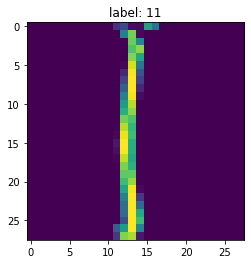

In [5]:
import random
i = random.randint(0,len(X_train))
plot_image(X_train[i], Y_train[i])
# print(f"i: {i}")
# image = X_train[i].reshape(28, 28)
# print(image)

In [10]:
image = np.resize(X_train[i],(25,25))

پیدا کردن ۲۰ کلاس مختلف:

In [6]:
different_classes = {}
for i in range(len(X_train)):
    if Y_train[i] not in different_classes:
        different_classes[Y_train[i]] = i
    if len(different_classes) >= 20:
        break
dictionary_items = different_classes.items()
different_classes = sorted(dictionary_items)

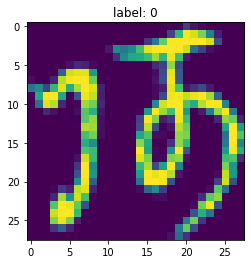

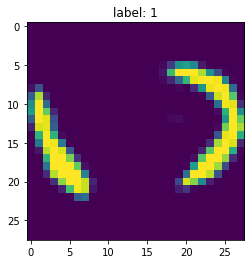

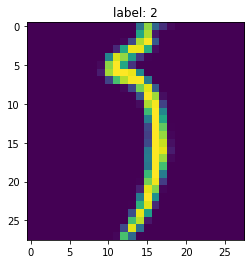

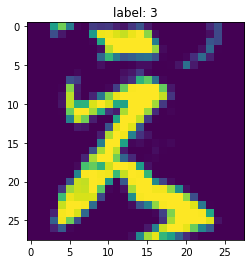

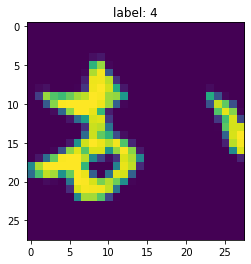

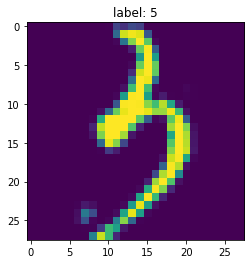

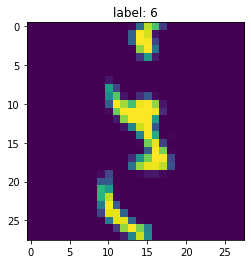

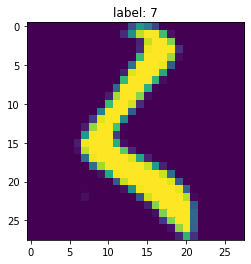

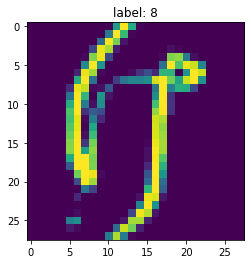

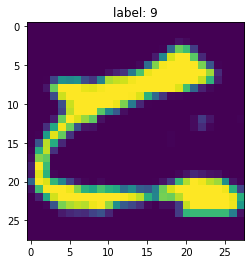

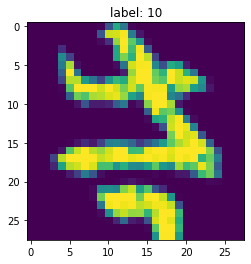

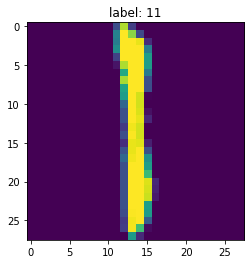

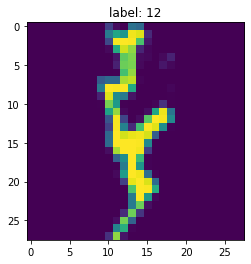

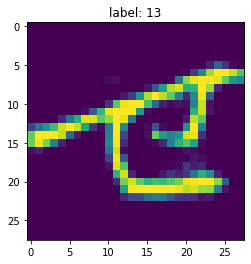

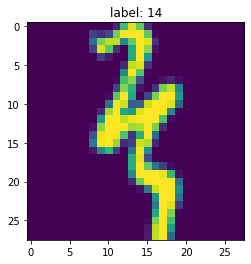

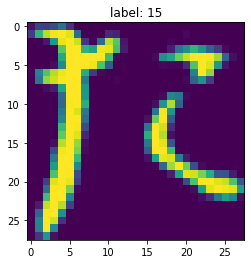

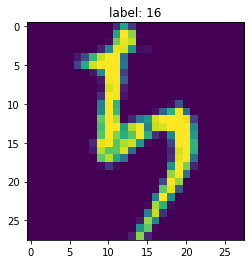

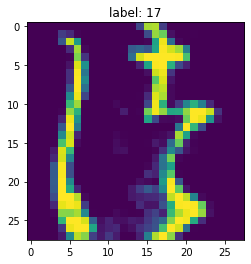

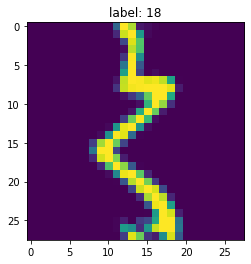

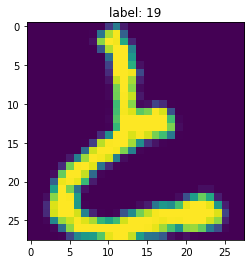

In [7]:
for i in(different_classes):
    plot_image(X_train[i[1]], Y_train[i[1]])

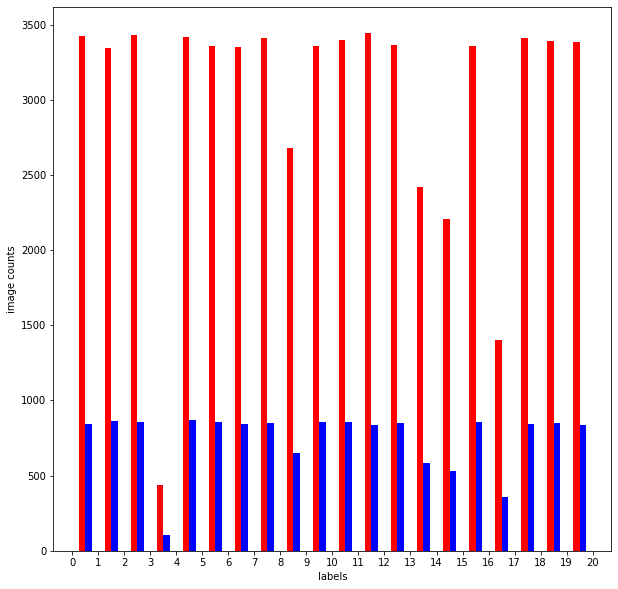

In [92]:
x_axis = np.arange(0, 21, 1)
plt.figure(figsize=(10, 10))
plt.hist([Y_train,Y_test], x_axis, rwidth=0.5, color= ['r', 'b'])
plt.xlabel("labels")
plt.ylabel("image counts")
plt.xticks(x_axis)
plt.show()

##### feature scaling

به دلیل این که داده ها در بازه [0,250] هستند می توان با تقسیم کردن به ۲۵۵ همه مقادیر  پیکسل ها را به بازه ۰ تا یک  scale کرد.

نرمال کردن داده ها در شبکه عصبی باعث می شود سرعت مدل سازی و الگوریتم بالا رود و سریع تر همگرا شود. و به دلیل این که خروجی هر لایه ورودی لایه بعد است اگر مقادیر ورودی نزدیک به صفر نباشند، برای لایه های آخر این مقدار بسیار بزرگ می شود.

In [9]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# Dataloader

In [10]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        # TODO: Implement check
        onehot_vectors = np.eye(n_classes)[labels]
        return onehot_vectors

    
    def __shuffle_dataset(self):
        # TODO: Implement check
        print("shuffle")
        p = np.random.permutation(len(self.__data))
        self.__data = self.__data[p]
        self.__onehot_labels = self.__onehot_labels[p]
        
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

In [11]:
data = Dataloader(X_train, Y_train, 20, batch_size=None, shuffle=True)

# Activation Functions

 توابع فعال ساز و مشتق های آن ها را پیاده سازی می کنیم:

In [27]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        # TODO: Implement check
        temp = np.matrix(matrix, dtype=float)
        relu_value = np.maximum(temp, 0)
        return relu_value

    def derivative(self, matrix):
        # TODO: Implement check
        temp = np.matrix(matrix, dtype=float)
        relu_derivative = (temp > 0) * 1
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class LeakyRelu:

    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01

    def __val(self, matrix):
        # TODO: Implement check
        temp = np.matrix(matrix, dtype=float)
        leacky_relu_value = np.matrix(np.where(temp < 0, temp * self.negative_slope, temp))
        return leacky_relu_value

    def derivative(self, matrix):
        # TODO: Implement check
        temp = np.matrix(matrix, dtype=float)
        leacky_relu_derivative = np.matrix(np.where(temp < 0, self.negative_slope, 1))
        return leacky_relu_derivative

    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        # TODO: Implement check
        temp = np.matrix(matrix, dtype=float)
        sigmoid_value = 1 / (1 + np.exp(-temp))
        return sigmoid_value

    def derivative(self, matrix):
        # TODO: Implement check
        temp = np.matrix(matrix, dtype=float)
        sigmoid = self.__val(temp)
        sigmoid_derivative = np.multiply(sigmoid, (1 - sigmoid))
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        # TODO: Implement check
        temp = np.matrix(matrix, dtype=float)
        e_x = np.exp(temp - np.max(temp, axis=1))
        sum_e = np.sum(e_x, axis=1)
        softmax_value = e_x / sum_e
        return softmax_value
    
    def __call__(self, matrix):
        return self.__val(matrix)
    
class Tanh:
    
    def __init__(self): pass

    def __val(self, matrix):
        # TODO: Implement check
        temp = np.matrix(matrix, dtype=float)
        tanh_value = (np.exp(temp) - np.exp(-temp)) / (np.exp(temp) + np.exp(-temp))
        return tanh_value

    def derivative(self, matrix):
        # TODO: Implement check
        temp = np.matrix(matrix, dtype=float)
        tanh_derivative = 1 - np.power(self.__val(temp), 2)
        return tanh_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

# Loss Function

In [13]:
class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val) == np.shape(expected_val)
        # TODO: Implement check
        softmax = Softmax()
        term1 = np.matrix(expected_val)
        term2 = np.log(softmax(true_val))
        cross_entropy_value = - np.sum(np.multiply(term1, term2), axis=1)
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        # TODO: Implement check
        softmax = Softmax()
        cross_entropy_derivative = softmax(true_val) - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

# Layer

In [14]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        # TODO: Implement check
        self.__last_input = layer_input
        self.__last_activation_input = np.add(np.dot(self.__last_input, self.__weight), self.__bias)
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        # TODO: Implement check
        backprop_tensor = np.matrix(backprop_tensor, dtype=float)
        delta = np.multiply(backprop_tensor, self.__last_activation_derivative)
        
        backprop_tensor = np.dot(backprop_tensor, self.__weight.T)
        
        self.__bias -= (lr * np.dot(np.ones((1, np.shape(backprop_tensor)[0])) ,delta))
        self.__weight -= (lr * np.dot(self.__last_input.T ,delta))
        
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        # TODO: Implement check
        weights = np.random.uniform(low, high, size=(dim1, dim2))
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        # TODO: Implement check
        weights = np.random.normal(loc=mean, scale=var, size=(dim1, dim2))
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

# Feed Forward Neural Network

In [15]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        # TODO: Implement check
        network_output = network_input
        for layer in self.__layers_list:
            network_output = layer.forward(network_output)
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        # TODO: Implement check
        predicted_val = self.forward(x_batch)
        self.__update_weights(predicted_val, y_batch)
        batch_accuracy = self.__compute_accuracy(predicted_val, y_batch)
        batch_average_loss = np.mean(self.__loss(predicted_val, y_batch))
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        # TODO: Implement check
        predicted_val = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(predicted_val, y_batch)
        batch_average_loss = np.mean(self.__loss(predicted_val, y_batch))
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        # TODO: Implement check
        labels = np.argmax(outputs, axis = 1)
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        # TODO: Implement check
        accuracy = np.sum(self.__get_labels(output) == self.__get_labels(expected_output)) / len(expected_output)
        return accuracy * 100
    
    
    def __update_weights(self, output, y_train):
        # TODO: Implement check
        backprop_tensor = self.__loss.derivative(output, y_train) #last layer
        for layer in reversed(self.__layers_list):
            backprop_tensor = layer.update_weights(backprop_tensor, self.__lr)
        return

# قسمت اول)

شبکه زیر دارای ۲ لایه پنهان و یک لایه خروجی می باشد. وزن ها نرمال درنظر گرفته شده و توابع فعال ساز Relu می باشند.

مشاهده می شود که دقت در هر  epoch افزایش می یابد و خطا کم می شود.

epoch تعداد دفعاتی است که کل داده های train پیمایش می شود.

داده ها به صورت دسته های ۶۴ تایی وارد شبکه می شوند و برای هر batch یک میانگین خطا گرفته می شود.

In [16]:
train_images_copy = np.copy(X_train)
train_labels_copy = np.copy(Y_train)
test_images_copy = np.copy(X_test)
test_labels_copy = np.copy(Y_test)
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20

train_loader = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
test_loader = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, train_loader, test_loader)

Epoch 1:
shuffle
	Train: Average Accuracy: 16.32795842217484	Average Loss: 2.58009229422532
shuffle
	Test: Average Accuracy: 28.76994680851064	Average Loss: 2.2539082657336302
Epoch 2:
shuffle
	Train: Average Accuracy: 58.665378464818765	Average Loss: 1.3906101492740082
shuffle
	Test: Average Accuracy: 57.340425531914896	Average Loss: 1.4887135336949449
Epoch 3:
shuffle
	Train: Average Accuracy: 71.76505863539445	Average Loss: 0.9911121623052399
shuffle
	Test: Average Accuracy: 63.328900709219866	Average Loss: 1.3080291452181558
Epoch 4:
shuffle
	Train: Average Accuracy: 77.16051439232409	Average Loss: 0.8076522503543375
shuffle
	Test: Average Accuracy: 69.78058510638297	Average Loss: 1.0863781783772006
Epoch 5:
shuffle
	Train: Average Accuracy: 80.57869136460555	Average Loss: 0.6828415092613342
shuffle
	Test: Average Accuracy: 71.70434397163122	Average Loss: 0.9964626007160332
Epoch 6:
shuffle
	Train: Average Accuracy: 82.79750799573561	Average Loss: 0.6075270781388218
shuffle
	Test: 

# قسمت دوم)

وزن ها در هر  iteration  تغییری نمی کنند و ثابت می مانند و درواقع به این معنی است که در هر  iteration اطلاعات جدیدی به نورون ها اضافه نمی شود. وزن ها حتما باید به صورت رندوم انتخاب شوند. در این صورت هر نورون feature متفاوتی از نورون ها را آموزش می بیند.

# قسمت سوم) 

پیدا کردن نرخ یادگیری بهینه:  نرخ یادگیری یکی از مهمترین هایپر پارامتر های مدل سازی می باشد. در ادامه سعی می کنیم بهینه ترین مقدار را برای آن پیدا کنیم.

### learning rate = 0.0002

از مقادیر کم شروع می شود و کم کم زیاد می شود. سرعت یادگیری مدل بسیار پایین تر می باشد به عنوان مثال در این قسمت در  epoch ۱۰ به دقت ۶۷ رسیده ولی در قسمت قبل با نرخ یادگیری تقریبا ۱۰ برابر در epoch ۱۰ دقت۸۷ دارد. 

زمان یادگیری مدل افزایش میابد. و برای رسیدن به دقت بالا و خطای کم به epoch های بیشتری نیاز دارد

In [17]:
train_images_copy = np.copy(X_train)
train_labels_copy = np.copy(Y_train)
test_images_copy = np.copy(X_test)
test_labels_copy = np.copy(Y_test)
INPUT_SHAPE = 784
LEARNING_RATE = 0.0002
EPOCHS = 20

train_loader = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
test_loader = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, train_loader, test_loader)

Epoch 1:
shuffle
	Train: Average Accuracy: 6.053438166311301	Average Loss: 2.929533626336505
shuffle
	Test: Average Accuracy: 6.866134751773049	Average Loss: 2.921137671681873
Epoch 2:
shuffle
	Train: Average Accuracy: 9.514925373134329	Average Loss: 2.88478436881749
shuffle
	Test: Average Accuracy: 12.531028368794328	Average Loss: 2.8691311917479227
Epoch 3:
shuffle
	Train: Average Accuracy: 18.26525852878465	Average Loss: 2.5804430939598344
shuffle
	Test: Average Accuracy: 18.3843085106383	Average Loss: 2.4824245210836073
Epoch 4:
shuffle
	Train: Average Accuracy: 23.20762260127932	Average Loss: 2.308923031908945
shuffle
	Test: Average Accuracy: 22.058953900709216	Average Loss: 2.3830345521981102
Epoch 5:
shuffle
	Train: Average Accuracy: 35.356143390191896	Average Loss: 2.061679716207024
shuffle
	Test: Average Accuracy: 38.09397163120567	Average Loss: 2.017122690013462
Epoch 6:
shuffle
	Train: Average Accuracy: 54.73414179104478	Average Loss: 1.543071183198705
shuffle
	Test: Average

### learning rate = 0.002

به دلیل این که از گرادیان کاهشی استفاده کرده ایم اگر learning rate را خیلی بزرگ در نظر بگیریم ممکن است در مینیمم محلی قرار بگیرد و دیگر همگرا نشود. ولی اگر این اتفاق نیوفتد الگوریتم سریع تر به جواب می رسد.

این مقدار برای نرخ یادگیری مناسب تر از ۰.۰۰۱ است. زیرا در نهایت دقت بالاتر و خطای کمتری دارد و الگوریتم سریع تر است.

In [22]:
train_images_copy = np.copy(X_train)
train_labels_copy = np.copy(Y_train)
test_images_copy = np.copy(X_test)
test_labels_copy = np.copy(Y_test)

INPUT_SHAPE = 784
LEARNING_RATE = 0.002
EPOCHS = 20

train_loader = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
test_loader = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, train_loader, test_loader)

Epoch 1:
shuffle
	Train: Average Accuracy: 32.06789712153518	Average Loss: 2.1408394495869554
shuffle
	Test: Average Accuracy: 52.95877659574468	Average Loss: 1.6259759822557938
Epoch 2:
shuffle
	Train: Average Accuracy: 71.12539978678038	Average Loss: 1.007635730958775
shuffle
	Test: Average Accuracy: 66.94148936170212	Average Loss: 1.1604837210571575
Epoch 3:
shuffle
	Train: Average Accuracy: 80.10061300639659	Average Loss: 0.6996164917643299
shuffle
	Test: Average Accuracy: 71.86613475177305	Average Loss: 1.0011371606962498
Epoch 4:
shuffle
	Train: Average Accuracy: 83.65704957356077	Average Loss: 0.5755277100411968
shuffle
	Test: Average Accuracy: 74.84485815602835	Average Loss: 0.9042251337915808
Epoch 5:
shuffle
	Train: Average Accuracy: 85.27285447761194	Average Loss: 0.5116794006429323
shuffle
	Test: Average Accuracy: 75.98404255319149	Average Loss: 0.8691790207687314
Epoch 6:
shuffle
	Train: Average Accuracy: 86.22734541577825	Average Loss: 0.4772860130173185
shuffle
	Test: Av

### learning rate = 0.002 * 10

همان طور که توضیح داده شد برای مقادیر lr بزرگ الگوریتم ممکن است در مینیمم محقلی قرار بگیرد و الگوریتم اصلا همگرا نشود.

In [19]:
train_images_copy = np.copy(X_train)
train_labels_copy = np.copy(Y_train)
test_images_copy = np.copy(X_test)
test_labels_copy = np.copy(Y_test)

INPUT_SHAPE = 784
LEARNING_RATE = 0.02
EPOCHS = 20

train_loader = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
test_loader = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, train_loader, test_loader)

Epoch 1:
shuffle
	Train: Average Accuracy: 5.54704157782516	Average Loss: 2.967984951623318
shuffle
	Test: Average Accuracy: 5.656028368794326	Average Loss: 2.9514729957162604
Epoch 2:
shuffle
	Train: Average Accuracy: 5.696961620469083	Average Loss: 2.9539191492206522
shuffle
	Test: Average Accuracy: 5.5828900709219855	Average Loss: 2.95197778963984
Epoch 3:
shuffle
	Train: Average Accuracy: 5.5653651385927505	Average Loss: 2.9542669045740375
shuffle
	Test: Average Accuracy: 5.824468085106383	Average Loss: 2.954830606028137
Epoch 4:
shuffle
	Train: Average Accuracy: 5.723614072494669	Average Loss: 2.9540839423448237
shuffle
	Test: Average Accuracy: 5.656028368794326	Average Loss: 2.951975783822235
Epoch 5:
shuffle
	Train: Average Accuracy: 5.823560767590618	Average Loss: 2.953932261515292
shuffle
	Test: Average Accuracy: 5.702570921985815	Average Loss: 2.9524676430852637
Epoch 6:
shuffle
	Train: Average Accuracy: 5.728611407249467	Average Loss: 2.9541301219205325
shuffle
	Test: Averag

### learning rate = 0.0002 * 0.1

به دلیل این که مقدار نرخ یادگیری بسیار کم است مدل به درستی آموزش نمی بیند. و در آخرین  epoch دقت ۲۰ را داریم.

In [20]:
train_images_copy = np.copy(X_train)
train_labels_copy = np.copy(Y_train)
test_images_copy = np.copy(X_test)
test_labels_copy = np.copy(Y_test)

INPUT_SHAPE = 784
LEARNING_RATE = 0.00002
EPOCHS = 20

train_loader = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
test_loader = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, train_loader, test_loader)

Epoch 1:
shuffle
	Train: Average Accuracy: 5.745269189765459	Average Loss: 2.94149186657708
shuffle
	Test: Average Accuracy: 5.871010638297872	Average Loss: 2.942331769732318
Epoch 2:
shuffle
	Train: Average Accuracy: 5.841884328358209	Average Loss: 2.932730279458965
shuffle
	Test: Average Accuracy: 5.649379432624113	Average Loss: 2.938245224013568
Epoch 3:
shuffle
	Train: Average Accuracy: 5.80190565031983	Average Loss: 2.929840944297271
shuffle
	Test: Average Accuracy: 6.722074468085107	Average Loss: 2.9358195264076925
Epoch 4:
shuffle
	Train: Average Accuracy: 5.95682302771855	Average Loss: 2.926530379195026
shuffle
	Test: Average Accuracy: 6.628989361702128	Average Loss: 2.9346927328232715
Epoch 5:
shuffle
	Train: Average Accuracy: 6.056769722814499	Average Loss: 2.9232041128652857
shuffle
	Test: Average Accuracy: 7.207446808510638	Average Loss: 2.931520708532993
Epoch 6:
shuffle
	Train: Average Accuracy: 6.2366737739872065	Average Loss: 2.920041580977002
shuffle
	Test: Average Acc

بنابر این بهینه ترین learnig rate از بین مقادیر بالا 0.002 می باشد.

# قسمت چهارم)

تاثیر activation function:

دلیل عملکرد نامناسب Tanh , Sigmoid:  


همان طور که مشاهده می شود tanh عملکرد بهتری نسبت sigmoid دارد.

هر دو تابع activation sigmoid  و tanh از نظر محاسباتی هزینه بالایی دارند. ایراد tanh  این است که زمانی که نورون ها به مقدار  1  یا  -1 بسیار نزدیک می شوند مقدار مشتق activation  آن ها بسیار نزدیک به صفر می شوند و این باعث غیرفعال شدن آن نورون ها می شود. 

در تابه فعال ساز  sigmoid  هم به طور مشابه  همین مشکل ها را دارد. هم هزینه محاسباتی بالایی دارد و هم مقادی مشتق activation برای داده های بزرگ سریع به صفر میل می کند.

### activation: Sigmoid

In [28]:
train_images_copy = np.copy(X_train)
train_labels_copy = np.copy(Y_train)
test_images_copy = np.copy(X_test)
test_labels_copy = np.copy(Y_test)

INPUT_SHAPE = 784
LEARNING_RATE = 0.002
EPOCHS = 20

train_loader = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
test_loader = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=Sigmoid(), weight_initializer='normal')
network.add_layer(30, activation=Sigmoid(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, train_loader, test_loader)

Epoch 1:
shuffle
	Train: Average Accuracy: 5.735274520255864	Average Loss: 2.9559315524505987
shuffle
	Test: Average Accuracy: 5.675975177304964	Average Loss: 2.951223553439257
Epoch 2:
shuffle
	Train: Average Accuracy: 6.068430170575693	Average Loss: 2.951840182705095
shuffle
	Test: Average Accuracy: 5.713652482269504	Average Loss: 2.9460175333985466
Epoch 3:
shuffle
	Train: Average Accuracy: 11.382262793176972	Average Loss: 2.7578670698094356
shuffle
	Test: Average Accuracy: 13.371010638297872	Average Loss: 2.565574587226511
Epoch 4:
shuffle
	Train: Average Accuracy: 18.766657782515992	Average Loss: 2.366898896583265
shuffle
	Test: Average Accuracy: 21.507092198581557	Average Loss: 2.3631339065888803
Epoch 5:
shuffle
	Train: Average Accuracy: 24.660181236673775	Average Loss: 2.176903736675984
shuffle
	Test: Average Accuracy: 27.644060283687942	Average Loss: 2.231885685386449
Epoch 6:
shuffle
	Train: Average Accuracy: 37.81816364605544	Average Loss: 1.8992898280660366
shuffle
	Test: A

### activation: Tanh

In [29]:

train_images_copy = np.copy(X_train)
train_labels_copy = np.copy(Y_train)
test_images_copy = np.copy(X_test)
test_labels_copy = np.copy(Y_test)

INPUT_SHAPE = 784
LEARNING_RATE = 0.002
EPOCHS = 20

train_loader = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
test_loader = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=Tanh(), weight_initializer='normal')
network.add_layer(30, activation=Tanh(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, train_loader, test_loader)

Epoch 1:
shuffle
	Train: Average Accuracy: 7.042910447761194	Average Loss: 2.9264883155339314
shuffle
	Test: Average Accuracy: 12.45345744680851	Average Loss: 2.6591837640539944
Epoch 2:
shuffle
	Train: Average Accuracy: 31.909648187633262	Average Loss: 2.0399394533480546
shuffle
	Test: Average Accuracy: 40.9906914893617	Average Loss: 1.9458794381400082
Epoch 3:
shuffle
	Train: Average Accuracy: 59.113472814498934	Average Loss: 1.3708153675729424
shuffle
	Test: Average Accuracy: 55.08421985815603	Average Loss: 1.5802605878302345
Epoch 4:
shuffle
	Train: Average Accuracy: 71.70175906183368	Average Loss: 0.9945693136191472
shuffle
	Test: Average Accuracy: 62.748226950354606	Average Loss: 1.3155585812352608
Epoch 5:
shuffle
	Train: Average Accuracy: 76.22767857142857	Average Loss: 0.8321587933005344
shuffle
	Test: Average Accuracy: 66.08820921985816	Average Loss: 1.1997210136881662
Epoch 6:
shuffle
	Train: Average Accuracy: 78.46981609808103	Average Loss: 0.7526107675239061
shuffle
	Test:

### activation: LeakyRelu

#### دلیل عملکرد بهتر LeakyRelu در مقایسه با  Relu: 

در مشتق  Relu برای همه مقادیر ورودی کوچکتر از صفر، مقدار صفر می گرفت و این اتفاق باعث غیر فعال کردن نورون های مربوط به آن می شد. در LeakyRelu به جای صفر، مقدار بسیار کوچک  0.001 را قرار می هیم. 

بنابر این، مقادیر گرادیانت برای داده های منفی، صفر نمی شود.

In [30]:
train_images_copy = np.copy(X_train)
train_labels_copy = np.copy(Y_train)
test_images_copy = np.copy(X_test)
test_labels_copy = np.copy(Y_test)

INPUT_SHAPE = 784
LEARNING_RATE = 0.002
EPOCHS = 20

train_loader = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
test_loader = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, train_loader, test_loader)

Epoch 1:
shuffle
	Train: Average Accuracy: 30.806902985074625	Average Loss: 2.1520163656633033
shuffle
	Test: Average Accuracy: 53.22916666666667	Average Loss: 1.5773734871234475
Epoch 2:
shuffle
	Train: Average Accuracy: 72.10987473347548	Average Loss: 0.9622591670745234
shuffle
	Test: Average Accuracy: 67.68395390070921	Average Loss: 1.157281645360514
Epoch 3:
shuffle
	Train: Average Accuracy: 80.24553571428571	Average Loss: 0.6900523351740984
shuffle
	Test: Average Accuracy: 71.66001773049645	Average Loss: 1.0363659603126074
Epoch 4:
shuffle
	Train: Average Accuracy: 83.70202558635394	Average Loss: 0.5710320052688811
shuffle
	Test: Average Accuracy: 74.20212765957447	Average Loss: 0.9422566650311686
Epoch 5:
shuffle
	Train: Average Accuracy: 85.25453091684435	Average Loss: 0.5129326332672562
shuffle
	Test: Average Accuracy: 75.70921985815602	Average Loss: 0.8922141830365696
Epoch 6:
shuffle
	Train: Average Accuracy: 86.18236940298507	Average Loss: 0.478889891806715
shuffle
	Test: Av

#  قسمت پنجم)

تاثیر batsch size:

### batch size = 16

زمان اجرای الگوریتم بسیار بالا می رود. به دلیل این که for روی batch ها تعداد  iteration های بیشتری دارد.  
و دقت و خطا تغییر چندانی نکرده است.

برای مقادیر batch size کم معمولا پایدار تر هستند و این به این دلیل است که نسبت به تفاوت های داده های آموزشی و تست مقاوم است. و احتمال overfit شدن مدل را کاهش می دهد.

برای batch size کوچک خطا نویزی است و بیشتر از قبل کم و زیاد می شود.

In [32]:
train_images_copy = np.copy(X_train)
train_labels_copy = np.copy(Y_train)
test_images_copy = np.copy(X_test)
test_labels_copy = np.copy(Y_test)

INPUT_SHAPE = 784
LEARNING_RATE = 0.002
EPOCHS = 20

train_loader = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=16, shuffle=True)
test_loader = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=16, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, train_loader, test_loader)

Epoch 1:
shuffle
	Train: Average Accuracy: 36.28333333333333	Average Loss: 2.0166464968953686
shuffle
	Test: Average Accuracy: 55.21721748400853	Average Loss: 1.5595908134665755
Epoch 2:
shuffle
	Train: Average Accuracy: 73.51666666666667	Average Loss: 0.9240734969111436
shuffle
	Test: Average Accuracy: 67.00426439232409	Average Loss: 1.176243635984385
Epoch 3:
shuffle
	Train: Average Accuracy: 81.11	Average Loss: 0.666140451270589
shuffle
	Test: Average Accuracy: 71.98160980810235	Average Loss: 0.9918128577569209
Epoch 4:
shuffle
	Train: Average Accuracy: 84.08666666666667	Average Loss: 0.5566338270805301
shuffle
	Test: Average Accuracy: 75.51972281449893	Average Loss: 0.8874101577950892
Epoch 5:
shuffle
	Train: Average Accuracy: 85.56833333333333	Average Loss: 0.4995566074313586
shuffle
	Test: Average Accuracy: 75.89952025586354	Average Loss: 0.8627726114808306
Epoch 6:
shuffle
	Train: Average Accuracy: 86.41166666666666	Average Loss: 0.46563189583556047
shuffle
	Test: Average Accura

### batch size = 32

In [34]:
train_images_copy = np.copy(X_train)
train_labels_copy = np.copy(Y_train)
test_images_copy = np.copy(X_test)
test_labels_copy = np.copy(Y_test)

INPUT_SHAPE = 784
LEARNING_RATE = 0.002
EPOCHS = 20

train_loader = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=32, shuffle=True)
test_loader = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=32, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, train_loader, test_loader)

Epoch 1:
shuffle
	Train: Average Accuracy: 35.79333333333334	Average Loss: 2.032358727404509
shuffle
	Test: Average Accuracy: 52.16995380241649	Average Loss: 1.5986427616976475
Epoch 2:
shuffle
	Train: Average Accuracy: 72.10166666666667	Average Loss: 0.9550815201772023
shuffle
	Test: Average Accuracy: 67.11531627576404	Average Loss: 1.1299225854785995
Epoch 3:
shuffle
	Train: Average Accuracy: 79.91166666666666	Average Loss: 0.695097685676815
shuffle
	Test: Average Accuracy: 71.37526652452026	Average Loss: 1.0098069462439894
Epoch 4:
shuffle
	Train: Average Accuracy: 83.21666666666667	Average Loss: 0.5798744381696697
shuffle
	Test: Average Accuracy: 73.39418976545842	Average Loss: 0.9427893622965648
Epoch 5:
shuffle
	Train: Average Accuracy: 84.595	Average Loss: 0.526704868994863
shuffle
	Test: Average Accuracy: 75.85287846481876	Average Loss: 0.8721143640040623
Epoch 6:
shuffle
	Train: Average Accuracy: 85.495	Average Loss: 0.4959007316769586
shuffle
	Test: Average Accuracy: 76.09719

### batch size = 256

مقدار batch بسیار بزرگ باعث می شود که در هر batch تعداد داده بیشتری در اپدیت شدن داده ها تاثیر می گذارد و به صورت همزمان در خطا و مدل سازی تاثیر می گذارند.بنابر این تاثیر هر داده به تنهایی بسیار کم می شود. در این صورت با وجود این که الگوریتم سریع تر می شود ولی ممکن است داده های مهم تاثیر کمی در آموزش مدل داشته باشند.

 خطای داده های آموزشی به نسبت قبل بیشتر شده است. و از طرفی به نظر می رسد تعداد  epoch بیشتری نیاز دارد تا به کمترین خطای داده های تست برسد. و کمترین خطای داده تست در بچ های کوچک تر کم تر بود.

In [82]:
train_images_copy = np.copy(X_train)
train_labels_copy = np.copy(Y_train)
test_images_copy = np.copy(X_test)
test_labels_copy = np.copy(Y_test)

INPUT_SHAPE = 784
LEARNING_RATE = 0.002
EPOCHS = 20

train_loader = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=256, shuffle=True)
test_loader = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=256, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, train_loader, test_loader)

Epoch 1:
shuffle
	Train: Average Accuracy: 15.460438829787234	Average Loss: 2.6321403244038653
shuffle
	Test: Average Accuracy: 25.088509143621767	Average Loss: 2.321908012194647
Epoch 2:
shuffle
	Train: Average Accuracy: 28.713984929078016	Average Loss: 2.2469654535744477
shuffle
	Test: Average Accuracy: 35.33257136485281	Average Loss: 2.160318370023343
Epoch 3:
shuffle
	Train: Average Accuracy: 47.50498670212766	Average Loss: 1.729205688933734
shuffle
	Test: Average Accuracy: 46.808792372881356	Average Loss: 1.818317521694465
Epoch 4:
shuffle
	Train: Average Accuracy: 59.60217198581561	Average Loss: 1.3492187909293019
shuffle
	Test: Average Accuracy: 49.77907560214095	Average Loss: 1.7056689534692377
Epoch 5:
shuffle
	Train: Average Accuracy: 66.7752659574468	Average Loss: 1.1410733943784679
shuffle
	Test: Average Accuracy: 58.416731712756466	Average Loss: 1.4498941953308853
Epoch 6:
shuffle
	Train: Average Accuracy: 71.51983599290782	Average Loss: 0.9870875118537884
shuffle
	Test: A

با توجه به این که batcjh size  در حالت ۳۲ و ۶۴ تاثیر یکسانی در تیجه داشت به دلیل سریع تر بودن ۶۴ را انتخاب می کنیم. و ادامه سوالات را با این مقدار به دست می آوریم.

# قسمت ششم)

تاثیر epoch:

### دلیل استفاده از  epoch:

epoch تعداد دفعاتی است که کل داده ها را بررسی می کنیم. اگر فقط یک بار این کار را انجام دهیم مدل  underfit می شود.  
و از طرفی اگر تعداد آن زیاد باشد مدل  overfit  می شود.  
بنابر این باید تعداد بهینه را برای آن پیدا کرد.

در این قسمت به دلیل زمان بر بودن یک لایه را حذف کردم. و تعداد epoch را ۱۰۰ درنظر گرفتم که تاثیر آن را بتوان به خوبی مشاهده کرد.

هنگامی که  overfit می شود یعنی خطا برای داده  train بسیار  کاهش میابد و نزدیک به صفر می شود ولی مدل برای داده جدید خوب کار نمی کند و دقت کم و خطای بالایی دارد. 

In [56]:
train_images_copy = np.copy(X_train)
train_labels_copy = np.copy(Y_train)
test_images_copy = np.copy(X_test)
test_labels_copy = np.copy(Y_test)

INPUT_SHAPE = 784
LEARNING_RATE = 0.002
EPOCHS = 100

train_loader = Dataloader(data=train_images_copy, labels=train_labels_copy, n_classes=20, batch_size=64, shuffle=True)
test_loader = Dataloader(data=test_images_copy, labels=test_labels_copy, n_classes=20, batch_size=64, shuffle=True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
# network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, train_loader, test_loader)

Epoch 1:
shuffle
	Train: Average Accuracy: 67.63726012793177	Average Loss: 1.1998764482642286
shuffle
	Test: Average Accuracy: 67.87234042553192	Average Loss: 1.169192214713143
Epoch 2:
shuffle
	Train: Average Accuracy: 80.69529584221749	Average Loss: 0.6994495186497943
shuffle
	Test: Average Accuracy: 72.38253546099291	Average Loss: 0.997329021496842
Epoch 3:
shuffle
	Train: Average Accuracy: 83.70202558635394	Average Loss: 0.5941564972345179
shuffle
	Test: Average Accuracy: 73.92065602836878	Average Loss: 0.9326232392482217
Epoch 4:
shuffle
	Train: Average Accuracy: 85.1662446695096	Average Loss: 0.5354929147530276
shuffle
	Test: Average Accuracy: 75.91533687943262	Average Loss: 0.8716472504990945
Epoch 5:
shuffle
	Train: Average Accuracy: 86.21068763326225	Average Loss: 0.4986967428769619
shuffle
	Test: Average Accuracy: 76.29432624113474	Average Loss: 0.8646325181740571
Epoch 6:
shuffle
	Train: Average Accuracy: 86.68876599147121	Average Loss: 0.47253506255609645
shuffle
	Test: Ave

	Train: Average Accuracy: 91.44622867803838	Average Loss: 0.2906472670145661
shuffle
	Test: Average Accuracy: 77.56205673758866	Average Loss: 0.9638516841881071
Epoch 48:
shuffle
	Train: Average Accuracy: 91.48953891257996	Average Loss: 0.2886031786836361
shuffle
	Test: Average Accuracy: 77.7061170212766	Average Loss: 0.9705780349663711
Epoch 49:
shuffle
	Train: Average Accuracy: 91.5994802771855	Average Loss: 0.28622019922003306
shuffle
	Test: Average Accuracy: 76.87278368794325	Average Loss: 0.9985041949326726
Epoch 50:
shuffle
	Train: Average Accuracy: 91.47954424307036	Average Loss: 0.2870852051356214
shuffle
	Test: Average Accuracy: 77.0567375886525	Average Loss: 1.005858267257653
Epoch 51:
shuffle
	Train: Average Accuracy: 91.6028118336887	Average Loss: 0.2850444039571434
shuffle
	Test: Average Accuracy: 77.40248226950355	Average Loss: 0.9899447472172481
Epoch 52:
shuffle
	Train: Average Accuracy: 91.50286513859275	Average Loss: 0.28409957574856615
shuffle
	Test: Average Accuracy

	Train: Average Accuracy: 92.52731876332622	Average Loss: 0.24616032707372126
shuffle
	Test: Average Accuracy: 75.89317375886526	Average Loss: 1.1916803476409414
Epoch 94:
shuffle
	Train: Average Accuracy: 92.64059168443497	Average Loss: 0.24518695881964128
shuffle
	Test: Average Accuracy: 76.6932624113475	Average Loss: 1.1546791196217396
Epoch 95:
shuffle
	Train: Average Accuracy: 92.50399786780383	Average Loss: 0.24481947242652216
shuffle
	Test: Average Accuracy: 76.2322695035461	Average Loss: 1.1725586046162373
Epoch 96:
shuffle
	Train: Average Accuracy: 92.61560501066099	Average Loss: 0.24482757674522965
shuffle
	Test: Average Accuracy: 76.57579787234043	Average Loss: 1.1736613294805736
Epoch 97:
shuffle
	Train: Average Accuracy: 92.52565298507463	Average Loss: 0.24286987495870177
shuffle
	Test: Average Accuracy: 76.66666666666666	Average Loss: 1.1603698759443182
Epoch 98:
shuffle
	Train: Average Accuracy: 92.64725479744136	Average Loss: 0.24188344883229282
shuffle
	Test: Average A

شیب داده های تست برای دقت رو به کاهش است به این معنی که با افزایش تعداد epoch ها مدل خیلی پیچیده می شود و هر چه پیچیده تر شود برای داده جدید  پیش بینی بدتری می کند و خطا بیشتر می شود.  
نمودار خطا هم برای داده تست رو به افزایش است.

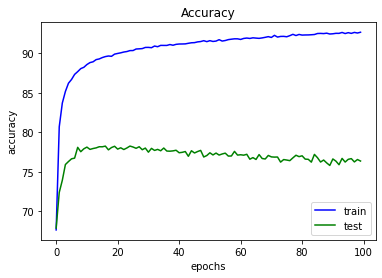

In [74]:
plt.plot(log['train_accuracy'], color='blue', label='train')
plt.plot(log['test_accuracy'], color='green', label='test')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

بهترین مقدار برای  epoch در جایی است که خطای train کم ترین مقدار خود می باشد که حدود ۱۰   است.

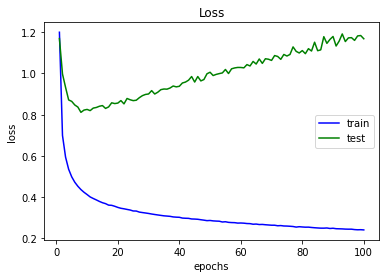

In [75]:
plt.plot(epochs, log['train_loss'], color='blue', label='train')
plt.plot(epochs, log['test_loss'], color='green', label='test')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

###  تعداد epoch  زیاد:

خیر همیشه تعدا زیاد  epoch مفید نیست و همان طور که مشاهده کردیم مدل را پیچیده می کند و  overfitting رخ می دهد.

### راه حل:

با استفاده از رسم نمودار ها مقدار بهینه را پیدا کنیم.
این کار معمولا بر روی داده های  validation صورت می گیرد ولی در این جا با داده های تست انجام دادیم.

# نتیجه گیری:

پیدا کردن هایپر پارامتر های مسئله تاثبر بسیاری در مدل سازی دارند.
یکی از بهترین روش های پیدا کردن این مقادیر رسم تاثیر تغییرات آن ها را تابع خطا و دقت می باشد. با توجه به نمودار های آن به راحتی می توان مقدار بهینه را پیدا کرد.
در مدل سازی شبکه عصبی باید به  overfitting توجه کرد در غیر این صورت مدل کارامد نخواهد بود.  
باید با توجه به داده ها و نوع ویژگی ها و تعداد نمونه های آموزشی مدل را آموزش داد و برای پیش بینی داده های جدید از آن استفاده کرد.

# Refrences

https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
https://stackoverflow.com/questions/50517545/how-do-i-implement-leaky-relu-using-numpy-functions
https://medium.com/@safrin1128/weight-initialization-in-neural-network-inspired-by-andrew-ng-e0066dc4a566#:~:text=Zero%20initialization%3A&text=If%20all%20the%20weights%20are,will%20produce%20a%20poor%20result.
https://medium.com/analytics-vidhya/comprehensive-synthesis-of-the-main-activation-functions-pros-and-cons-dab105fe4b3b
https://www.mygreatlearning.com/blog/relu-activation-function/
https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
https://medium.com/deep-learning-experiments/effect-of-batch-size-on-neural-net-training-c5ae8516e57

In [94]:
import os
os.system('jupyter nbconvert --to html AI-CA5-P1-810896059.ipynb')

0